In [1]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer,porter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import pandas
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import RandomForestRegressor as rfr
from scipy.stats import spearmanr as spcorr,pearsonr as pcorr
from IPython.display import display
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [185]:
def maxCase(x):
    result = [i for (i,v) in zip(range(-2,3),[y==max(x) for y in x]) if v]
    if(len(result) > 1):
        s = sum(result)
        if(s < -2):
            return -2
        elif(s > 2):
            return 2
        else:
            return s
    else:
        return result[0]
    
def worstCase(x):
    if x['vneg']>0:
        return -2
    elif x['neg']>0:
        return -1
    elif x['neutral']>0:
        return 0
    elif x['pos']>0:
        return 1
    else:
        return 2
    
def bestCase(x):
    if x['vpos']>0:
        return 2
    elif x['pos']>0:
        return 1
    elif x['neutral']>0:
        return 0
    elif x['neg']>0:
        return -1
    else:
        return -2

sentiments = pandas.read_csv('review_sentiment_coreNLP.txt')
sentiments_R = pandas.read_csv('Score_of_reviews.csv')['scores']
scores = sentiments.apply(maxCase,axis=1)

In [186]:
reviews = pandas.read_pickle('consumer_affairs_sallie_mae.data')
reviews['sentiment'] = scores
reviews.sentiment.value_counts()

-1    1273
 0      23
-2      10
 1       4
Name: sentiment, dtype: int64

In [187]:
def noPunct(txt):
    for punct in string.punctuation:
        txt = txt.replace(punct,'')
    return txt

def noNumber(txt):
    return re.sub(r'[$\s]*\d+\.?\d*','',txt)

def LemmaTokenizer(doc):
    wnl = WordNetLemmatizer()
    lemmas =[wnl.lemmatize(t) for t in word_tokenize(doc)]
    lemmas = [noPunct(l) for l in lemmas]
    lemmas = [noNumber(l) for l in lemmas]
    lemmas = list(filter(lambda x: len(x) > 0,lemmas))
    return lemmas

def StemmerTokenizer(doc):
    port = porter.PorterStemmer()
    tokens =[port.stem(t) for t in word_tokenize(doc)]
    tokens = [noPunct(l) for l in tokens]
    tokens = [noNumber(l) for l in tokens]
    tokens = list(filter(lambda x: len(x) > 0,tokens))
    return tokens

extra_stopwords = stopwords.words('english') + ['sallie','mae','loan','nt','va','le','ha']

In [230]:
tfidf = TfidfVectorizer(lowercase=True, analyzer='word', stop_words=extra_stopwords,tokenizer=LemmaTokenizer,
                        ngram_range=(1,2), binary=False, norm='l1', use_idf=True, smooth_idf=True, sublinear_tf=True,
                       max_features=None,min_df=1,max_df=0.99)
data = tfidf.fit_transform(reviews.review)

In [231]:
model = rfc(n_estimators=1000,criterion='entropy',max_features='auto',bootstrap=False,oob_score=False,n_jobs=6,
           random_state=20170202,verbose=1)
model.fit(data,reviews.sentiment)

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    2.6s
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:    3.3s finished


RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=6,
            oob_score=False, random_state=20170202, verbose=1,
            warm_start=False)

In [232]:
features = tfidf.get_feature_names()
importance = model.feature_importances_
feature_summary = pandas.DataFrame({'name':features,'value':list(importance)})
feature_summary.sort_values('value',ascending=False,inplace=True)

In [233]:
n = 25
ngrams = feature_summary.head(n).index

In [234]:
rho = []
pval = []
for a in ngrams:
    r,p = spcorr(data[:,a].toarray().flatten(),reviews.sentiment.values)
    rho.append(r)
    pval.append(p)
    del r,p

In [235]:
corr_summary = pandas.DataFrame({'name':feature_summary.head(n).name,'cor':rho,'pval':pval})
pandas.options.display.max_rows=n
corr_summary.sort_values('cor')

,cor,name,pval
64108,-0.234205,offer refinancing,8.817950e-18
76829,-0.122418,refinancing,8.860113e-06
102888,-0.083655,would,2.443787e-03
64061,-0.062711,offer,2.321785e-02
67466,-0.033691,pay,2.229946e-01
36113,-0.022423,fact,4.174111e-01
92041,-0.019848,talked,4.729114e-01
74945,-0.018029,rate,5.144195e-01
52452,-0.016647,late,5.471773e-01
89744,-0.004755,student,8.634887e-01


In [229]:
cormat = np.corrcoef(np.transpose(data[:,ngrams].todense()))
cormat_df = pandas.DataFrame(cormat,columns=feature_summary.loc[ngrams,'name'],index=feature_summary.loc[ngrams,'name'])
cormat_df.to_excel('ngram_corr.xlsx')

,datetime,location,name,rating,review,sentiment
1,2017-01-03 16:46:44,"Stevenson Ranch, CA",Joe,1.0,I had student loan with CitiBank. I moved to n...,-1.8
3,2016-11-08 23:55:28,"Knoxville, TN",K. L.,1.0,"I signed (and aunt cosigned) for a $10,000 loa...",-5.2
4,2016-10-30 21:13:14,"San Jose, CA",M. A.,1.0,"I have a student loan in Sallie Mae, and as so...",-4.6
6,2016-10-25 21:57:07,"Milwaukee, WI",Tony,1.0,So I took a loan out from Sallie Mae to cover ...,-3.6
10,2016-08-30 02:51:48,"North Tonawanda, NY",Taylor,1.0,"Where to begin with this company, they've been...",-2.4
16,2016-07-25 05:05:55,"Germantown, MD",marilyn,1.0,I co-signed for a loan for my son who is out o...,-2.2
18,2016-07-17 22:27:13,"Mays Landing, NJ",jim,1.0,I wish I had read these reviews prior to falli...,-3.2
19,2016-07-05 15:35:17,"Chicopee, MA",David,1.0,Sallie Mae is the worst loan company I have wo...,-7.2
23,2016-06-04 23:40:39,"Brenham, TX",Alexis,1.0,"I was told, by my financial adviser, that Sall...",-2.0
24,2016-06-01 03:52:58,"Laguna Niguel, CA",farrah,1.0,I applied to Sallie Mae based off of my colleg...,-2.4


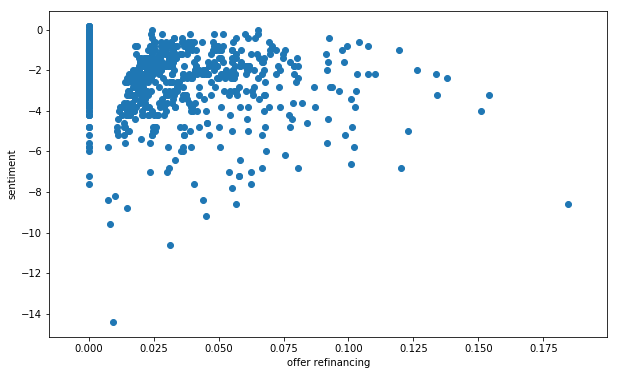

In [518]:
mask = [x > 0 for x in data[:,84569].toarray().flatten()]

display(reviews.iloc[mask])

plt.scatter(data[:,84569].toarray().flatten(),reviews.sentiment)
plt.xlabel('offer refinancing')
plt.ylabel('sentiment')
plt
plt.show()